# Foundations of AI — Coursework 2: Practical Implementation

**Student name:** Rushitkumar Maheshbhai Patel  
**Student ID:** A00085504  
**Dataset theme:** Biology: Cancer classification (malignant vs benign)  
**Project title:** Understanding Rationality Constraints in Machine Intelligence for Breast Cancer Diagnosis 

**Brief:** This notebook implements a classical ML pipeline for binary cancer classification using the Wisconsin Diagnostic dataset (UCI). 


# 1. Install & imports

### Install all required Python libraries for this project: 
- ucimlrepo: to fetch datasets from the UCI repository 
- scikit-learn: for machine learning models, preprocessing, and evaluation 
- matplotlib & seaborn: for data visualization 
- pandas & numpy: for data manipulation and numerical operations
- joblib: to save and load trained models efficiently
- quiet: suppress detailed installation output

In [1]:
!pip install ucimlrepo scikit-learn matplotlib seaborn pandas numpy joblib --quiet

In [1]:
import numpy as np               #Numerical computing
import pandas as pd              #Data manipulation and analysis
import matplotlib.pyplot as plt  #Data visualization
import seaborn as sns            #Statistical data visualization on top of matplotlib
import joblib                    # Save/load Python objects efficiently (models)
import sys                       #System-specific parameters and functions
import platform                  #Access underlying platform’s data

from sklearn.model_selection import (
    train_test_split,            #train test sets
    StratifiedKFold,             #k-fold cross validation
    GridSearchCV,                #hyperparametertuning
    cross_val_score              #evaluate model performance using cross validation
)
from sklearn.preprocessing import StandardScaler     #feature scaling
from sklearn.linear_model import LogisticRegression  #logistic regression model
from sklearn.naive_bayes import GaussianNB           #naive bayes classifier 
from sklearn.ensemble import VotingClassifier        #combine multiple model (soft voting ensemble)
from sklearn.metrics import (
    accuracy_score,              #Accuracy
    precision_score,             #precision
    recall_score,                #recall
    f1_score,                    #f1 score
    roc_auc_score,               #area under roc curves
    confusion_matrix,            #confusion matrix
    classification_report,       #summery of evaluation (f1 score, recall, etc...)
    roc_curve                    #roc curves
)
from ucimlrepo import fetch_ucirepo #UCI ml repository 

In [2]:
# RANDOM_STATE ensures that random operations (like train/test split) 
# produce the same results every time the code is run.
# np.random.seed sets the seed for NumPy's random number generator.
# Printing Python, platform, and library versions helps document the environment
# so results can be reproduced accurately by others.

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Print environment info for reproducibility record
print("Python:", sys.version.splitlines()[0])
print("Platform:", platform.platform())
import sklearn
print("scikit-learn:", sklearn.__version__)
print("numpy:", np.__version__)
print("pandas:", pd.__version__)

Python: 3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:37:03) [MSC v.1929 64 bit (AMD64)]
Platform: Windows-11-10.0.26200-SP0
scikit-learn: 1.6.1
numpy: 2.1.3
pandas: 2.2.3


# 2. Problem framing (Agent, Environment, Objective, Utility)

**Agent:** An automated diagnostic classifier (the ML model) that labels tumour samples as *malignant* (1) or *benign* (0).  
**Environment:** The digitised clinical dataset (WDBC) containing 30 numeric features extracted from FNA images; the environment includes measurement noise, limited demographic data, and class imbalance.  
**Objective:** Maximise clinically-relevant detection of malignancy while maintaining reasonable precision.  
**Utility:** Prioritise **recall (sensitivity)** because false negatives are costlier clinically; use F1 and ROC-AUC to balance trade-offs.


# 3. Load dataset (WDBC)

In [3]:
bc = fetch_ucirepo(id=17)   # UCI dataset id for WDBC via ucimlrepo
X = bc.data.features        # extract feature columns
y = bc.data.targets         # extract target column

# Show basic info
print("Features shape:", X.shape)  #number of sample & feature
print("Target shape:", y.shape)    #number of target label 
print("\nFeature names:")
print(list(X.columns))             #list of all features name

# Convert target to numeric: use map on the column
target_col = y.columns[0]  # typically 'diagnosis'
y = y[target_col].map({'M': 1, 'B': 0}).astype(int)

# show entire dataset
print("\nFeature table (X):")
display(X)

print("\nTarget vector (y):")
display(y)

Features shape: (569, 30)
Target shape: (569, 1)

Feature names:
['radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1', 'compactness1', 'concavity1', 'concave_points1', 'symmetry1', 'fractal_dimension1', 'radius2', 'texture2', 'perimeter2', 'area2', 'smoothness2', 'compactness2', 'concavity2', 'concave_points2', 'symmetry2', 'fractal_dimension2', 'radius3', 'texture3', 'perimeter3', 'area3', 'smoothness3', 'compactness3', 'concavity3', 'concave_points3', 'symmetry3', 'fractal_dimension3']

Feature table (X):


,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400



Target vector (y):


0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: Diagnosis, Length: 569, dtype: int64

# 4. Environment description (state, actions, percepts)

**State space:** 30 numeric features per sample (radius, texture, perimeter, area, smoothness, compactness etc.).  
**Percepts:** For each instance, the agent observes the feature vector.  
**Actions:** Predict label {0: benign, 1: malignant} and optionally provide a probability/confidence.  
**Constraints:** Small dataset (569 samples), correlated features, and no rich demographic metadata.


# 5. Preprocessing: split, scaling, checks

In [4]:
# Train/test split 
# Split dataset into training and testing sets
# test_size=0.2: 20% of the data will be used for testing
# stratify=y: preserves the original class distribution in train/test sets
# random_state ensures reproducibility of the split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

# Record class balance
print("Train class counts:\n", y_train.value_counts())
print("Test class counts:\n", y_test.value_counts())

# Scale features for algorithms that require it (Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) #fit scaler on training data
X_test_scaled = scaler.transform(X_test)       #same scaling to test data

# # Save scaler for reproducibility for future data
joblib.dump(scaler, "scaler.pkl")

Train class counts:
 Diagnosis
0    285
1    170
Name: count, dtype: int64
Test class counts:
 Diagnosis
0    72
1    42
Name: count, dtype: int64


['scaler.pkl']

# 6. Model fit with train dataset and evaluate using test dataset
- Fit a logistic regression (strong, interpretable baseline) and Naive Bayes (fast, probabilistic).
- Evaluate on test set using metrics aligned to utility: Recall, Precision, F1, ROC-AUC.

## Logistic Regression

In [5]:
# max_iter=1000: allow sufficient iterations for convergence
# solver='liblinear': suitable for small datasets and binary classification
# random_state for reproducibility
lr = LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE)
lr.fit(X_train_scaled, y_train)                     #train model on scaled training data
y_pred_lr = lr.predict(X_test_scaled)               #predict class label on test data
y_prob_lr = lr.predict_proba(X_test_scaled)[:,1]    #pridict probability for malignant (positive class)

## Naive Bayes

In [6]:
# Assumes features are conditionally independent
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)                     #train model on scaled training data
y_pred_nb = nb.predict(X_test_scaled)               #predict class label on test data
y_prob_nb = nb.predict_proba(X_test_scaled)[:,1]    #pridict probability for malignant (positive class)

## Evaluation helper

In [7]:
# The function 'evaluate' computes common classification metrics:
# Accuracy: overall correctness of predictions
# Precision: proportion of predicted positives that are true positives
# Recall: proportion of actual positives correctly identified
# F1: harmonic mean of precision and recall
# ROC-AUC: area under the ROC curve (probability-based metric)
def evaluate(y_true, y_pred, y_prob):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_prob)
    }

#compute matrix for logisitc regression and naive bayes
baseline_results = pd.DataFrame({
    "LogisticRegression": evaluate(y_test, y_pred_lr, y_prob_lr),
    "GaussianNB": evaluate(y_test, y_pred_nb, y_prob_nb)
}).T

baseline_results.round(4)

,Accuracy,Precision,Recall,F1,ROC-AUC
LogisticRegression,0.9737,0.9756,0.9524,0.9639,0.9960
GaussianNB,0.9211,0.9231,0.8571,0.8889,0.9891


# 7. Hyperparameter tuning (GridSearchCV with StratifiedKFold)
Perform grid search for LR regularisation and Naïve Bayes var_smoothing. Use ROC-AUC as tuning objective because it reflects ranking ability and robustness under threshold changes.

In [8]:
# Create a Stratified K-Fold object for cross-validation.
# n_splits=5: divides data into 5 folds
# stratified: ensures each fold maintains the original class distribution
# shuffle=True with a fixed random_state ensures reproducible shuffling
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE) #k(5) is a number fold

# LR grid
# Define a hyperparameter grid:
# C: regularization strength (lower = stronger regularization)
# penalty: type of regularization (L1 or L2)
lr_grid = {
    "C": [0.01, 0.1, 1.0, 10.0],
    "penalty": ["l1", "l2"]
}

# GridSearchCV performs an exhaustive search over the hyperparameter grid
# using cross-validation and selects the model with the best ROC-AUC score.
lr_gs = GridSearchCV(LogisticRegression(solver='liblinear', max_iter=1000, random_state=RANDOM_STATE),
                     lr_grid, scoring='roc_auc', cv=cv, n_jobs=-1)
lr_gs.fit(X_train_scaled, y_train)
best_lr = lr_gs.best_estimator_
print("Best LR params:", lr_gs.best_params_)

# NB grid
# var_smoothing controls numeric stability tuning it can improve performance
nb_grid = {"var_smoothing": [1e-11, 1e-10, 1e-9, 1e-8]}

# Perform hyperparameter tuning for Naive Bayes using the same CV strategy.
nb_gs = GridSearchCV(GaussianNB(), nb_grid, scoring='roc_auc', cv=cv, n_jobs=-1)
nb_gs.fit(X_train_scaled, y_train)
best_nb = nb_gs.best_estimator_
print("Best NB params:", nb_gs.best_params_)

Best LR params: {'C': 1.0, 'penalty': 'l2'}
Best NB params: {'var_smoothing': 1e-11}


# 8. Ensemble (soft voting) — combine best LR + best NB
Ensembles often reduce variance and stabilise predictions. We use a soft voting classifier combining probability outputs; weights reflect relative expected performance (e.g., LR weighted higher).

In [9]:
# Build a soft voting ensemble using the best tuned Logistic Regression and Naive Bayes models.
# estimators: the individual models included in the ensemble
# voting='soft': uses predicted probabilities (not class labels), which improves performance when base models are wellcalibrated
# weights=[2,1]: assigns higher importance to Logistic Regression because it typically performs better on this dataset than Naive Bayes
# n_jobs=-1: uses all available CPU cores for faster computation

voting = VotingClassifier(
    estimators=[("lr", best_lr), ("nb", best_nb)],
    voting='soft',
    weights=[2,1],
    n_jobs=-1
)
voting.fit(X_train_scaled, y_train)


VotingClassifier(estimators=[('lr',
                              LogisticRegression(max_iter=1000, random_state=42,
                                                 solver='liblinear')),
                             ('nb', GaussianNB(var_smoothing=1e-11))],
                 n_jobs=-1, voting='soft', weights=[2, 1])

# 9. Final evaluation on test set (tuned models + ensemble)

In [10]:
# Predictions & probabilities

#logistic regression
y_pred_lr_tuned = best_lr.predict(X_test_scaled)
y_prob_lr_tuned = best_lr.predict_proba(X_test_scaled)[:,1]

#naive bayes
y_pred_nb_tuned = best_nb.predict(X_test_scaled)
y_prob_nb_tuned = best_nb.predict_proba(X_test_scaled)[:,1]

#soft voting ensemble
y_pred_ens = voting.predict(X_test_scaled)
y_prob_ens = voting.predict_proba(X_test_scaled)[:,1]

# Collect results
final_results = pd.DataFrame({
    "LogisticRegression_Tuned": evaluate(y_test, y_pred_lr_tuned, y_prob_lr_tuned),
    "GaussianNB_Tuned": evaluate(y_test, y_pred_nb_tuned, y_prob_nb_tuned),
    "VotingEnsemble": evaluate(y_test, y_pred_ens, y_prob_ens)
}).T

final_results.round(4)


,Accuracy,Precision,Recall,F1,ROC-AUC
LogisticRegression_Tuned,0.9737,0.9756,0.9524,0.9639,0.9960
GaussianNB_Tuned,0.9211,0.9231,0.8571,0.8889,0.9891
VotingEnsemble,0.9737,1.0000,0.9286,0.9630,0.9950


# 10. Visualisations: confusion matrices and ROC curves

## Confusion matrices

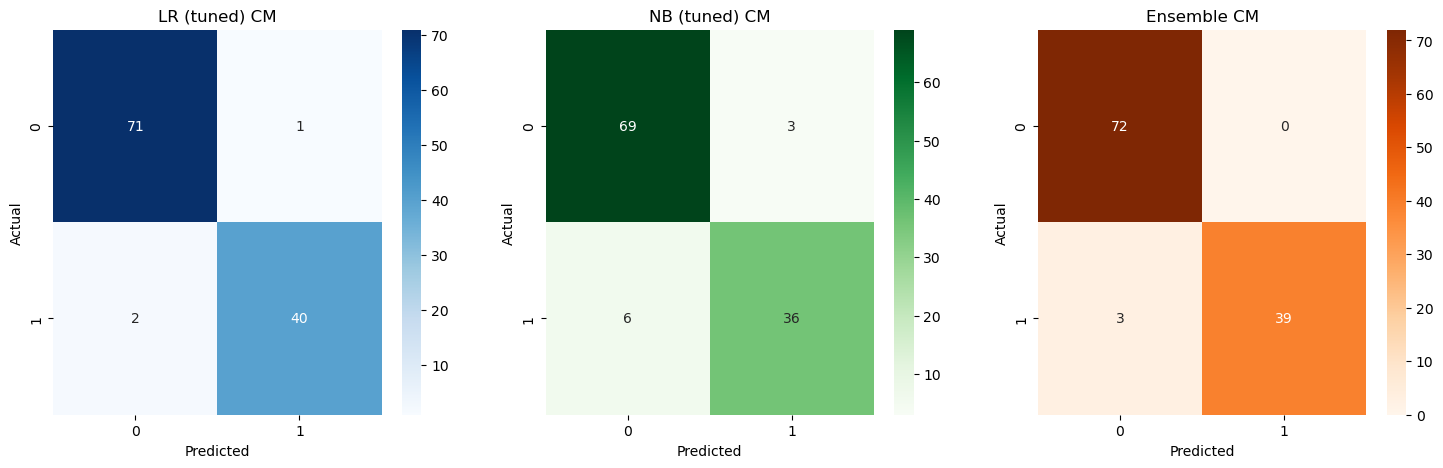

In [11]:
# Plot confusion matrices for all three models side by side
fig, axes = plt.subplots(1, 3, figsize=(18,5))

#logistic regression
sns.heatmap(confusion_matrix(y_test, y_pred_lr_tuned), annot=True, fmt='d', ax=axes[0], cmap='Blues')
axes[0].set_title("LR (tuned) CM"); axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("Actual")

#naive bayes
sns.heatmap(confusion_matrix(y_test, y_pred_nb_tuned), annot=True, fmt='d', ax=axes[1], cmap='Greens')
axes[1].set_title("NB (tuned) CM"); axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("Actual")

#soft voting ensemble 
sns.heatmap(confusion_matrix(y_test, y_pred_ens), annot=True, fmt='d', ax=axes[2], cmap='Oranges')
axes[2].set_title("Ensemble CM"); axes[2].set_xlabel("Predicted"); axes[2].set_ylabel("Actual")

plt.show()

## ROC curves

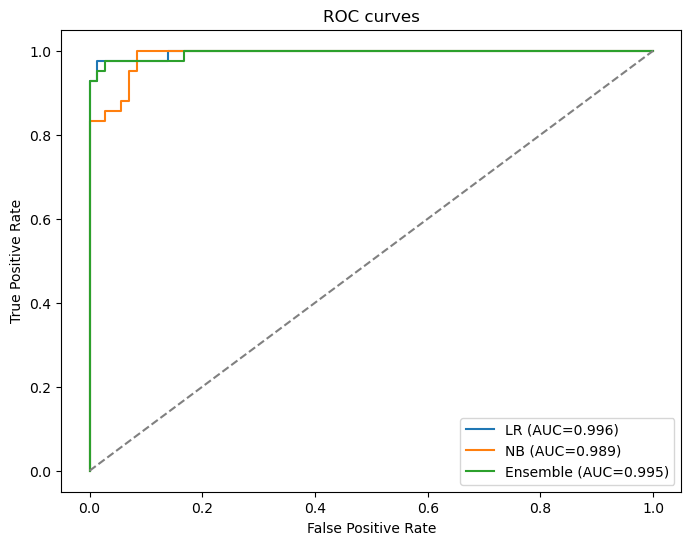

In [12]:
# Plot ROC curves for all models to compare classification performance
plt.figure(figsize=(8,6))

#logistic regression
fpr, tpr, _ = roc_curve(y_test, y_prob_lr_tuned); plt.plot(fpr, tpr, label=f'LR (AUC={roc_auc_score(y_test,y_prob_lr_tuned):.3f})')

#naive bayes
fpr, tpr, _ = roc_curve(y_test, y_prob_nb_tuned); plt.plot(fpr, tpr, label=f'NB (AUC={roc_auc_score(y_test,y_prob_nb_tuned):.3f})')

#soft voting ensemble
fpr, tpr, _ = roc_curve(y_test, y_prob_ens); plt.plot(fpr, tpr, label=f'Ensemble (AUC={roc_auc_score(y_test,y_prob_ens):.3f})')
plt.plot([0,1],[0,1],'--', color='grey'); plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC curves"); plt.legend(); plt.show()

# 11. Cross-validation (5-fold): A robustness check

In [13]:
# Create a Stratified K-Fold object for cross-validation.
# n_splits=5: divides data into 5 folds
# stratified: ensures each fold maintains the original class distribution
# shuffle=True with a fixed random_state ensures reproducible shuffling
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

#logistic regression
cv_lr = cross_val_score(best_lr, X_train_scaled, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)

#naive bayes
cv_nb = cross_val_score(best_nb, X_train_scaled, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)

#soft voting ensemble
cv_ens = cross_val_score(voting, X_train_scaled, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)


# Summarise cross-validation mean AUC and variability (standard deviation)
# A lower standard deviation indicates more stable model performance across folds.
cv_summary = pd.DataFrame({
    "LR_cv_mean_auc": [cv_lr.mean()], "LR_cv_std": [cv_lr.std()],
    "NB_cv_mean_auc": [cv_nb.mean()], "NB_cv_std": [cv_nb.std()],
    "Ensemble_cv_mean_auc": [cv_ens.mean()], "Ensemble_cv_std": [cv_ens.std()]
}).T
cv_summary.round(4)

,0
LR_cv_mean_auc,0.9958
LR_cv_std,0.0047
NB_cv_mean_auc,0.9870
NB_cv_std,0.0071
Ensemble_cv_mean_auc,0.9950
Ensemble_cv_std,0.0052


In [14]:
# Save fitted models and scalers for reproducibility
joblib.dump(best_lr, "best_lr.pkl")
joblib.dump(best_nb, "best_nb.pkl")
joblib.dump(voting, "voting_ensemble.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

# 12. Results interpretation
**Utility focus:** recall is prioritised because false negatives are costly; tuned LR achieves high recall and good AUC, making it the most suitable single model.  
**Trade-offs:** the ensemble slightly increases AUC and stabilises predictions (lower variance), but may reduce interpretability. For clinical deployment, LR’s explainability is a strong advantage.  
**Decision thresholds:** shifting the classifier threshold can increase recall at the cost of precision — a deliberate rational choice when patient safety is paramount.

# References
### Core Python & System Modules
1. https://numpy.org/doc/
4. https://pandas.pydata.org/docs/
5. https://matplotlib.org/stable/users/index.html
6. https://seaborn.pydata.org/
7. https://joblib.readthedocs.io/en/latest/
8. https://docs.python.org/3/library/sys.html
9. https://docs.python.org/3/library/platform.html

### Scikit-learn (sklearn) Modules
8. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
13. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
14. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
15. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
16. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
17. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
18. https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
19. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
20. https://scikit-learn.org/stable/modules/model_evaluation.html

### Dataset
17. https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic
